In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/content/drive/MyDrive/Brain_MRI_100"
#test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224 x 3
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)



Found 200 images belonging to 2 classes.


In [ ]:
a,b=train_data.next()

In [ ]:
class_indices = train_data.class_indices
print(class_indices)


{'No_100': 0, 'YES_100': 1}


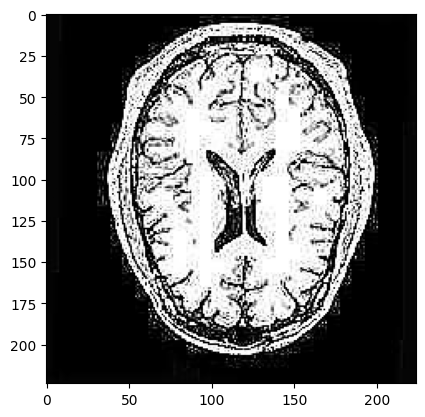

In [ ]:
plt.imshow(a[0])

#Using ReconNet model for training the images



In [3]:
def my_model():
  inputs=keras.Input(shape=(224, 224,3))
  e1 =tf.keras.layers.Conv2D(32, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1))(inputs)
  e2 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1))(e1)
  e3 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e2)
  e4 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1))(e3)
  e5 = tf.keras.layers.Conv2D(1, 7, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1))(e4)
  e6 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e5)
  e7 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1))(e4)
  e8 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1))(e5)
  e9 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e8)
  flatten_layer=tf.keras.layers.Flatten()(e9)
  dense_layer1 = tf.keras.layers.Dense(1089, activation='relu')(flatten_layer)
  dense_layer2 = tf.keras.layers.Dense(720, activation='relu')(dense_layer1)
  output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer2)



  model=tf.keras.Model(inputs=inputs,outputs=output_layer)

  return model


In [ ]:
model=my_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      11648     
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      247872    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 1)       1569      
                                                             

In [4]:


def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())



def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(y_true * tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(y_true)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())


In [ ]:
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=["accuracy"])

In [ ]:
history= model.fit(train_data,
                  epochs=20,
                  steps_per_epoch=len(train_data),
                  #validation_data=valid_data,
                    #validation_steps=len(valid_data)
                  )

Text(0.5, 1.0, 'Accuracy vs Epochs')

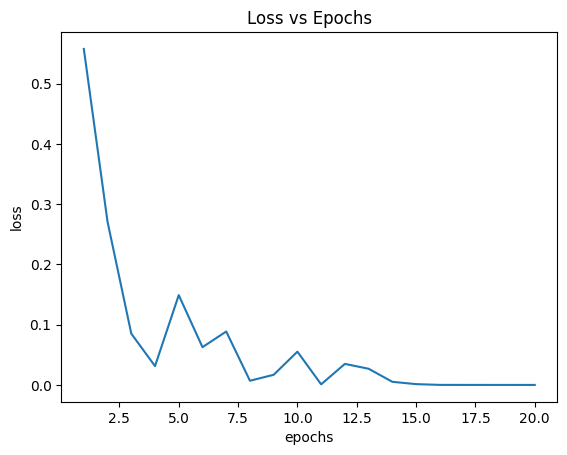

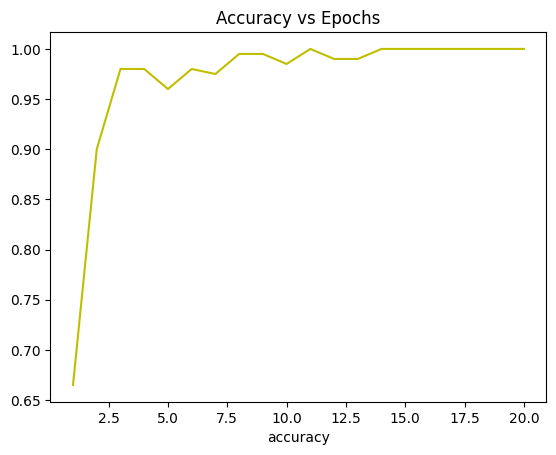

In [ ]:
import pandas as pd
df=pd.DataFrame(history.history)
df.head()

#plotting loss vs epochs
x=[i for i in range(1,len(df)+1)]
loss=df['loss']
acc=df['accuracy']
plt.plot(x,loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')
plt.figure()
plt.plot(x,acc,color='y')
plt.xlabel('epochs')
plt.xlabel('accuracy')
plt.title('Accuracy vs Epochs')


# Validating the model

In [ ]:
test_dir = "/content/drive/MyDrive/Brain_MRI_validation"

# Import data from directories and turn it into batches
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224 x 3
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

Found 40 images belonging to 2 classes.


In [ ]:
class_indices_valid = valid_data.class_indices
print(class_indices_valid)


{'No': 0, 'yes': 1}


In [ ]:
model.evaluate(valid_data)


2/2 [==============================] - 0s 41ms/step - loss: 0.8827 - accuracy: 0.9000


[0.8827188611030579, 0.8999999761581421]

Looks like model is getting overfitted


# Adding regularization term for the CNN model

In [ ]:
from keras.regularizers import l2

In [ ]:
def my_model_reg(num_classes):
  inputs=keras.Input(shape=(224, 224,3))
  e1 =tf.keras.layers.Conv2D(32, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.01))(inputs)
  e2 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.01))(e1)
  e3 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e2)
  e4 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.01))(e3)
  e5 = tf.keras.layers.Conv2D(1, 7, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.01))(e4)
  e6 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e5)
  e7 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.01))(e4)
  e8 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.01))(e5)
  e9 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e8)
  flatten_layer=tf.keras.layers.Flatten()(e9)
  dense_layer1 = tf.keras.layers.Dense(1089, activation='relu')(flatten_layer)
  dense_layer2 = tf.keras.layers.Dense(720, activation='relu')(dense_layer1)
  output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dense_layer2)



  model=tf.keras.Model(inputs=inputs,outputs=output_layer)

  return model


In [ ]:
model_reg=my_model_reg(1)

In [ ]:
model_reg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      11648     
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      247872    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 1)       1569      
                                                           

In [ ]:
# Compile the model
model_reg.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy",precision,recall])

In [ ]:
history_reg= model_reg.fit(train_data,
                  epochs=20,
                  steps_per_epoch=len(train_data),
                  )

Text(0.5, 1.0, 'Accuracy vs Epochs')

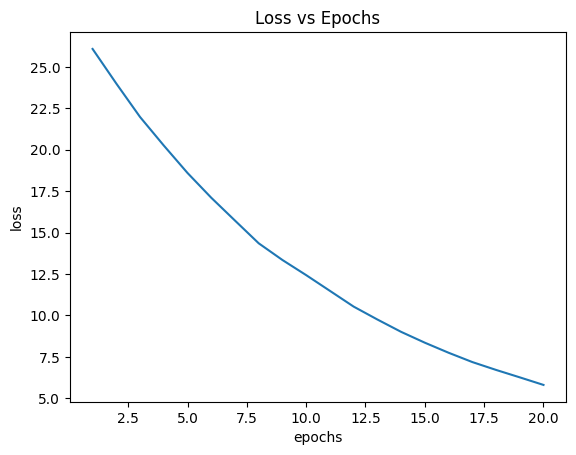

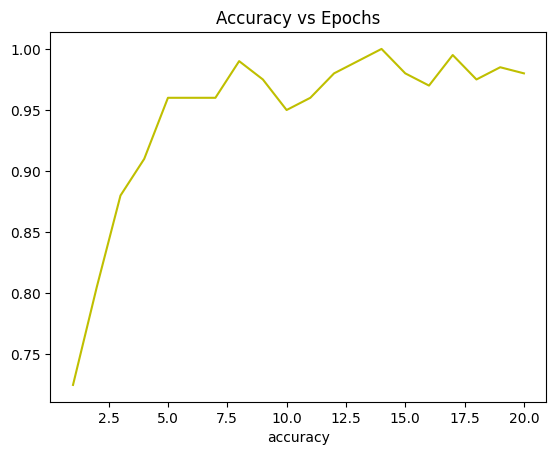

In [ ]:
import pandas as pd
df=pd.DataFrame(history_reg.history)
df.head()

#plotting loss vs epochs
x=[i for i in range(1,len(df)+1)]
loss=df['loss']
acc=df['accuracy']
plt.plot(x,loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')
plt.figure()
plt.plot(x,acc,color='y')
plt.xlabel('epochs')
plt.xlabel('accuracy')
plt.title('Accuracy vs Epochs')


In [ ]:
model_reg.evaluate(valid_data)

2/2 [==============================] - 0s 42ms/step - loss: 6.8906 - accuracy: 0.8000 - precision: 0.7143 - recall: 0.8611


[6.890555381774902, 0.800000011920929, 0.7142857313156128, 0.8611111044883728]

# Incresing the strength of the regularization parameter

In [ ]:
def my_model_reg_2(num_classes):
  inputs=keras.Input(shape=(224, 224,3))
  e1 =tf.keras.layers.Conv2D(32, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.1))(inputs)
  e2 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.1))(e1)
  e3 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e2)
  e4 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.1))(e3)
  e5 = tf.keras.layers.Conv2D(1, 7, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.1))(e4)
  e6 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e5)
  e7 = tf.keras.layers.Conv2D(64, 11, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.1))(e4)
  e8 = tf.keras.layers.Conv2D(32, 1, padding='same', activation=tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.1),kernel_regularizer=l2(0.1))(e5)
  e9 = tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid")(e8)
  flatten_layer=tf.keras.layers.Flatten()(e9)
  dense_layer1 = tf.keras.layers.Dense(1089, activation='relu')(flatten_layer)
  dense_layer2 = tf.keras.layers.Dense(720, activation='relu')(dense_layer1)
  output_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dense_layer2)



  model=tf.keras.Model(inputs=inputs,outputs=output_layer)

  return model


In [ ]:
model_reg_2=my_model_reg_2(1)

In [ ]:
model_reg_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      11648     
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      247872    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 32)      2080      
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 1)       1569      
                                                           

In [ ]:
# Compile the model
model_reg_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [ ]:
history_reg_2= model_reg_2.fit(train_data,
                  epochs=20,
                  steps_per_epoch=len(train_data),
                  )

Epoch 1/20
7/7 [==============================] - 5s 217ms/step - loss: 250.9429 - accuracy: 0.6500
Epoch 2/20
7/7 [==============================] - 2s 200ms/step - loss: 227.8960 - accuracy: 0.7950
Epoch 3/20
7/7 [==============================] - 1s 186ms/step - loss: 207.9654 - accuracy: 0.8400
Epoch 4/20
7/7 [==============================] - 1s 191ms/step - loss: 192.4920 - accuracy: 0.8850
Epoch 5/20
7/7 [==============================] - 1s 187ms/step - loss: 177.2458 - accuracy: 0.9600
Epoch 6/20
7/7 [==============================] - 1s 229ms/step - loss: 162.8643 - accuracy: 0.9750
Epoch 7/20
7/7 [==============================] - 2s 202ms/step - loss: 151.6311 - accuracy: 0.9800
Epoch 8/20
7/7 [==============================] - 1s 190ms/step - loss: 139.4534 - accuracy: 0.9750
Epoch 9/20
7/7 [==============================] - 1s 205ms/step - loss: 128.5676 - accuracy: 0.9900
Epoch 10/20
7/7 [==============================] - 1s 194ms/step - loss: 119.6651 - accuracy: 0.9850

Text(0.5, 1.0, 'Accuracy vs Epochs')

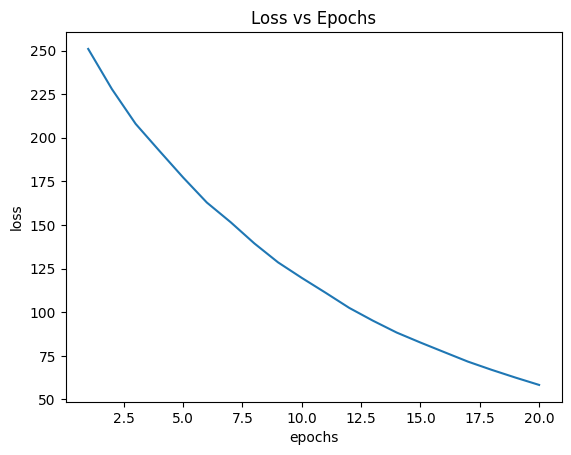

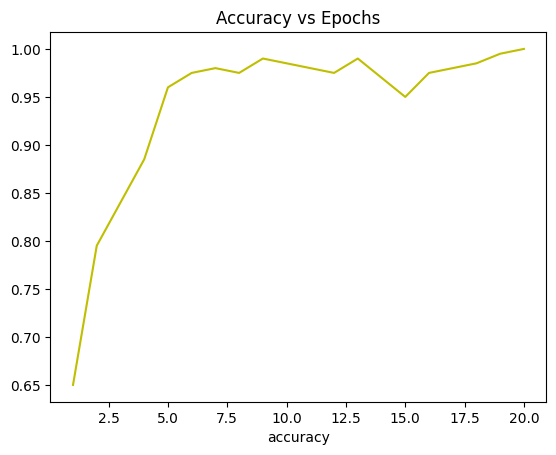

In [ ]:
import pandas as pd
df=pd.DataFrame(history_reg_2.history)
df.head()

#plotting loss vs epochs
x=[i for i in range(1,len(df)+1)]
loss=df['loss']
acc=df['accuracy']
plt.plot(x,loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')
plt.figure()
plt.plot(x,acc,color='y')
plt.xlabel('epochs')
plt.xlabel('accuracy')
plt.title('Accuracy vs Epochs')


In [ ]:
model_reg_2.evaluate(valid_data)

2/2 [==============================] - 1s 41ms/step - loss: 57.0731 - accuracy: 0.8000


[57.0731086730957, 0.800000011920929]

# Changing Mini-batch Gradient descent to Gradiant Descent

In [ ]:

# Import data from directories and turn it into batches
train_data_nobatch = train_datagen.flow_from_directory(train_dir,
                                               batch_size=1, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224 x 3
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)


Found 200 images belonging to 2 classes.


In [ ]:
model_2=my_model(1)

In [ ]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 224, 224, 32)      11648     
                                                                 
 conv2d_31 (Conv2D)          (None, 224, 224, 64)      247872    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 112, 112, 32)      2080      
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 1)       1569      
                                                           

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy",precision,recall])

In [ ]:
history_2= model_2.fit(train_data_nobatch,
                  epochs=20,
                  steps_per_epoch=len(train_data_nobatch),
                  )

Epoch 1/20
200/200 [==============================] - 15s 49ms/step - loss: 1.9915 - accuracy: 0.4650 - precision: 0.2100 - recall: 0.2100
Epoch 2/20
200/200 [==============================] - 11s 53ms/step - loss: 0.6938 - accuracy: 0.4300 - precision: 0.3450 - recall: 0.3450
Epoch 3/20
200/200 [==============================] - 10s 51ms/step - loss: 0.6937 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000
Epoch 4/20
200/200 [==============================] - 10s 52ms/step - loss: 0.6936 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000
Epoch 5/20
200/200 [==============================] - 10s 51ms/step - loss: 0.7193 - accuracy: 0.5100 - precision: 0.1100 - recall: 0.1100
Epoch 6/20
200/200 [==============================] - 10s 50ms/step - loss: 0.6949 - accuracy: 0.4800 - precision: 0.0050 - recall: 0.0050
Epoch 7/20
200/200 [==============================] - 10s 50ms/step - loss: 0.6941 - accuracy: 0.5100 - precision: 0.0100 - recall: 0.0100
Epoch 8/20
200/200 [=======

Text(0.5, 1.0, 'Accuracy vs Epochs')

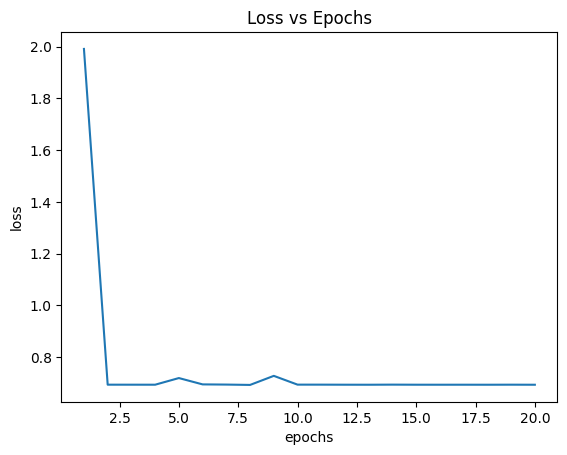

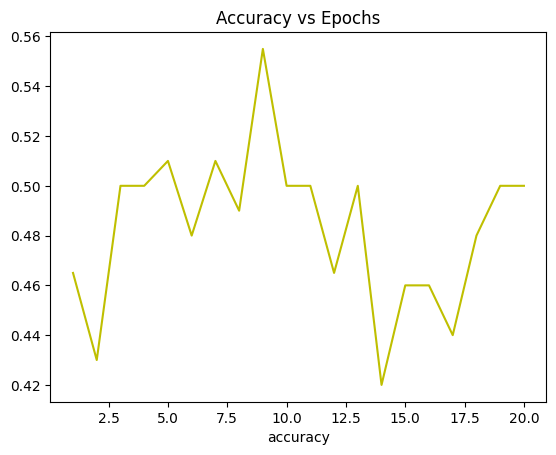

In [ ]:
import pandas as pd
df=pd.DataFrame(history_2.history)
df.head()

#plotting loss vs epochs
x=[i for i in range(1,len(df)+1)]
loss=df['loss']
acc=df['accuracy']
plt.plot(x,loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')
plt.figure()
plt.plot(x,acc,color='y')
plt.xlabel('epochs')
plt.xlabel('accuracy')
plt.title('Accuracy vs Epochs')


# Training the model with the whole 11k images

In [5]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)


# Setup the train and test directories
train_dir = "/content/drive/MyDrive/Brain_MRI_images"
#test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data_whole = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224 x 3
                                               class_mode="binary", # type of problem we're working on
                                               seed=42,
                                               subset='training')


valid_data_whole = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224 x 3
                                               class_mode="binary", # type of problem we're working on
                                               seed=42,
                                               subset='validation')



Found 9356 images belonging to 2 classes.
Found 2337 images belonging to 2 classes.


In [6]:
len(valid_data_whole)

74

In [7]:
model_all=my_model()

In [8]:
model_all.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      11648     
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      247872    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 1)       1569      
                                                             

In [9]:
# Compile the model
model_all.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [10]:
history_all= model_all.fit(train_data_whole,
                  epochs=20,
                  steps_per_epoch=len(train_data_whole),
                  validation_data=valid_data_whole,
                  validation_steps=len(valid_data_whole))

Epoch 1/20
293/293 [==============================] - 2710s 9s/step - loss: 0.2649 - accuracy: 0.8910 - val_loss: 0.1939 - val_accuracy: 0.9191
Epoch 2/20
293/293 [==============================] - 67s 229ms/step - loss: 0.0573 - accuracy: 0.9799 - val_loss: 0.0885 - val_accuracy: 0.9820
Epoch 3/20
293/293 [==============================] - 68s 233ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0072 - val_accuracy: 0.9983
Epoch 4/20
293/293 [==============================] - 68s 233ms/step - loss: 3.2527e-05 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9991
Epoch 5/20
293/293 [==============================] - 68s 233ms/step - loss: 6.2766e-06 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 0.9987
Epoch 6/20
293/293 [==============================] - 68s 233ms/step - loss: 3.2962e-06 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 0.9987
Epoch 7/20
293/293 [==============================] - 68s 231ms/step - loss: 2.1201e-06 - accuracy: 1.0000 - val_loss: 

In [13]:
import pandas as pd
data_all=pd.DataFrame(history_all.history)
data_all.head()


,loss,accuracy,val_loss,val_accuracy
0,0.264882,0.890979,0.193947,0.919127
1,0.057338,0.979906,0.088499,0.982028
2,0.007076,0.997969,0.007182,0.998288
3,0.000033,1.000000,0.004014,0.999144
4,0.000006,1.000000,0.003945,0.998716


Text(0.5, 1.0, 'Validation accuracy vs Epochs')

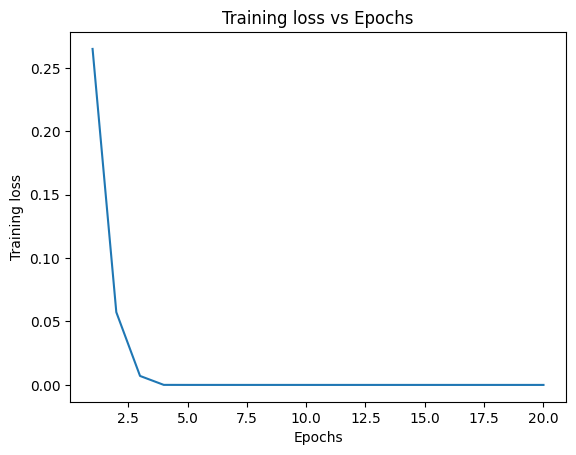

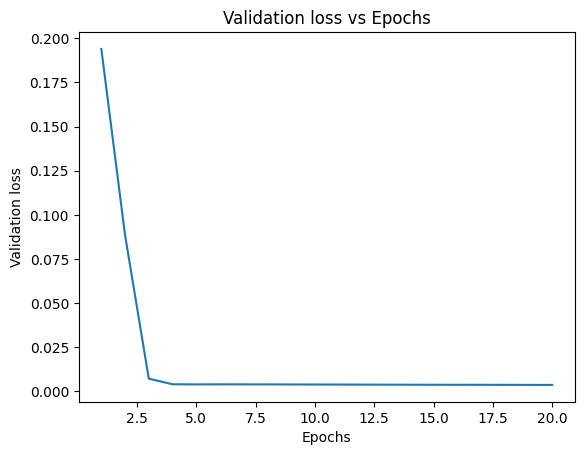

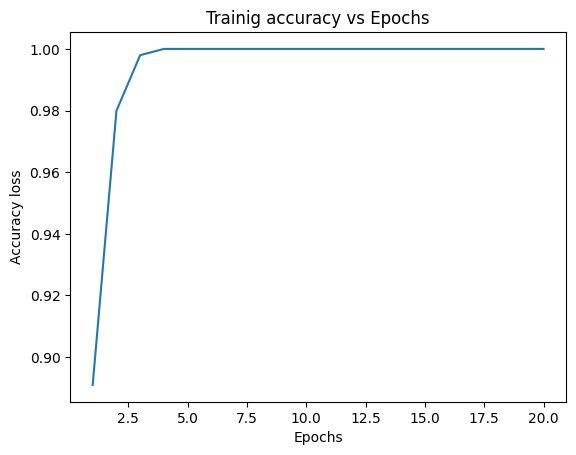

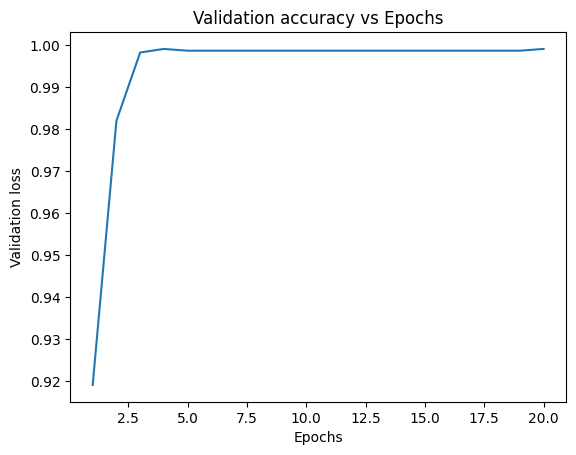

In [14]:
train_loss=data_all['loss']
train_acc=data_all['accuracy']
val_loss=data_all['val_loss']
val_accuracy=data_all['val_accuracy']

#plotting
x_axis=[i for i in range(1,21)]
plt.plot(x_axis,train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss vs Epochs')

plt.figure()
plt.plot(x_axis,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss vs Epochs')


plt.figure()
plt.plot(x_axis,train_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy loss')
plt.title('Trainig accuracy vs Epochs')

plt.figure()
plt.plot(x_axis,val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Validation accuracy vs Epochs')


In [15]:
#saving and dowmloading model
model_all.save('model_all.h5')

In [18]:
from google.colab import files

# Download the model file
files.download('model_all.h5')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import os

# Get the size of the model file in bytes
model_file_path = '/content/model_all.h5'
file_size_bytes = os.path.getsize(model_file_path)
print(file_size_bytes)

# Convert bytes to human-readable format (e.g., KB, MB, GB)
def convert_bytes(byte_size):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if byte_size < 1024:
            return f"{byte_size:.2f} {unit}"
        byte_size /= 1024

# Print the file size
print("Model file size:", convert_bytes(file_size_bytes))


1324072772
Model file size: 1.23 GB
